# **Welcome to the MRInference machine learning tutorial!**
by Sandra Vieira

---
This webpage contains a brief step-by-step tutorial on the implementation of a standard supervised machine learning pipeline using Python programming language.

---
##Machine Learning: Methods and Applications to Brain Disorders
This tutorial is based on the book [Machine Learning: Methods and Applications to Brain Disorders](https://www.sciencedirect.com/book/9780128157398/machine-learning). This tutorial is a shorter version of Chapter 19. You can access the full tutorial of Chapter 19 [here](https://github.com/MLMH-Lab/How-To-Build-A-Machine-Learning-Model).

---  
## Aim and structure of the tutorial
For this tutorial you will use a toy dataset containing the grey matter volume and thickness from different brain regions extracted with FreeSurfer to classify patients with schizophrenia and healthy controls using a Support Vector Machine (SVM). The script and data for the tutorial are stored [here](https://github.com/sandramv/ML_Tutorial). The main steps of the tutrial will follow the pipeline presented in the lecture 2.

![workflow](https://raw.githubusercontent.com/sandramv/ML_Tutorial/master/Figures/pipeline.png)



## Import libraries

Python language is organised in libraries. Each library contains a set of functions for a specific purpose. For example, numpy is a popular library for manipulating numerical data, while pandas is most commonly used to handle tabular data. There are several libraries for machine learning analysis; in this tutorial we will use scikitlearn.

In [1]:
# SNIPPET 1: import libraries

# Manipulate data
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical tests
import scipy.stats as stats

# Machine learning
from sklearn.svm import LinearSVC
import joblib
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold

# Ignore WARNING
import warnings
warnings.filterwarnings('ignore')

## Set random seed
Some steps in our analysis will be subjected to randomness.  We should set the  seed value to a fixed number to guarantee that we get the same results every time we run the code.

In [2]:
# SNIPPET 2: set random seed
random_seed = 1
np.random.seed(random_seed)

## 1. Problem formulation

 In this tutorial, our machine learning problem is:

> *Classify patients with schizophrenia and healthy controls using structural MRI data.*

From this formulation we can derive the main elements of our machine learning problem:

*   **Features**: Structural MRI data
*   **Task**: Binary classification
*   **Target**: Patients with schizophrenia and healthy controls



---



## 2. Data preparation

The aim of this step is to perform a series of statistical analyses to get the data ready for the machine learning model. In this tutorial, we will assume the data is ready to be analysed. However, in a real project we would want to pay close attention to several things including class imbalance (N HC vs N SZ), missing data (data imputation?), confounding variables (age, sex?), dimensionality (N features vs N participants).

### Load data

In [3]:
# SNIPPET 3: load data
dataset_url = 'https://raw.githubusercontent.com/sandramv/ML_tutorial/main/Data/ml_tutorial_data.csv'
dataset_df = pd.read_csv(dataset_url, index_col='ID')

In [4]:
# SNIPPET 4: preview data
dataset_df[0:6]

,Diagnosis,Sex,Left Lateral Ventricle,Left Inf Lat Vent,Left Cerebellum White Matter,Left Cerebellum Cortex,Left Thalamus Proper,Left Caudate,Left Putamen,Left Pallidum,...,rh rostralanteriorcingulate thickness,rh rostralmiddlefrontal thickness,rh superiorfrontal thickness,rh superiorparietal thickness,rh superiortemporal thickness,rh supramarginal thickness,rh frontalpole thickness,rh temporalpole thickness,rh transversetemporal thickness,rh insula thickness
ID,,,,,,,,,,,,,,,,,,,,,
c001,0,0,4226.907844,414.407845,12242.90784,43410.50784,7020.107844,4133.407844,6467.707844,2048.207844,...,2.440844,2.522844,2.656844,2.123844,2.638844,2.420844,2.489844,2.235844,2.300844,2.645844
c002,0,0,4954.912699,414.812699,16519.51270,38808.31270,7013.312699,3882.912699,5781.012699,1735.912699,...,2.507699,2.470699,2.645699,2.132699,2.848699,2.425699,2.883699,2.622699,2.322699,2.673699
c003,0,0,4470.611989,370.111989,10193.51199,38637.51199,5802.911989,2941.711989,5802.511989,1467.411989,...,2.545989,2.589989,2.885989,2.317989,2.326989,2.454989,2.482989,2.232989,2.267989,2.795989
c004,0,0,7553.310654,521.010654,12716.01065,41933.31065,5998.310654,2869.110654,5854.810654,1886.210654,...,2.323654,2.411654,2.770654,2.149654,2.458654,2.307654,3.284654,1.956654,2.297654,2.731654
c005,0,0,8785.212771,396.912771,12077.41277,41818.91277,5839.812771,3614.812771,6013.112771,1550.712771,...,3.211771,2.467771,2.772771,2.051771,2.588771,2.325771,3.266771,3.162771,2.081771,2.607771
c006,0,0,5083.706643,172.106643,11927.50664,38730.80664,5693.506643,3422.606643,6301.706643,1466.806643,...,2.562643,2.603643,2.948643,2.177643,2.489643,2.362643,2.314643,3.512643,2.591643,2.606643


In [5]:
# SNIPPET 5: sample size and number of features
print('Number of features = %d' % dataset_df.shape[1])
print('Number of participants = %d' % dataset_df.shape[0])

Number of features = 171
Number of participants = 426


In [6]:
# SNIPPET 6: number of healthy controls (HC=0) and patients (SZ=1)
dataset_df['Diagnosis'].value_counts()

,count
Diagnosis,
0,368
1,58


### Feature set and target

Our next step is to retrieve the target and features from the dataset.

In [7]:
# SNIPPET 7: get target and input features
targets_df = dataset_df['Diagnosis']

features_names = dataset_df.columns[3:]
features_df = dataset_df[features_names]

In [8]:
# SNIPPET 8: see features
features_df

,Left Inf Lat Vent,Left Cerebellum White Matter,Left Cerebellum Cortex,Left Thalamus Proper,Left Caudate,Left Putamen,Left Pallidum,rd Ventricle,th Ventricle,Brain Stem,...,rh rostralanteriorcingulate thickness,rh rostralmiddlefrontal thickness,rh superiorfrontal thickness,rh superiorparietal thickness,rh superiortemporal thickness,rh supramarginal thickness,rh frontalpole thickness,rh temporalpole thickness,rh transversetemporal thickness,rh insula thickness
ID,,,,,,,,,,,,,,,,,,,,,
c001,414.407845,12242.90784,43410.50784,7020.107844,4133.407844,6467.707844,2048.207844,825.507845,1751.707844,18918.50784,...,2.440844,2.522844,2.656844,2.123844,2.638844,2.420844,2.489844,2.235844,2.300844,2.645844
c002,414.812699,16519.51270,38808.31270,7013.312699,3882.912699,5781.012699,1735.912699,457.512699,1123.312699,20193.91270,...,2.507699,2.470699,2.645699,2.132699,2.848699,2.425699,2.883699,2.622699,2.322699,2.673699
c003,370.111989,10193.51199,38637.51199,5802.911989,2941.711989,5802.511989,1467.411989,835.011989,1050.011989,17577.51199,...,2.545989,2.589989,2.885989,2.317989,2.326989,2.454989,2.482989,2.232989,2.267989,2.795989
c004,521.010654,12716.01065,41933.31065,5998.310654,2869.110654,5854.810654,1886.210654,867.310654,1577.310654,17785.41065,...,2.323654,2.411654,2.770654,2.149654,2.458654,2.307654,3.284654,1.956654,2.297654,2.731654
c005,396.912771,12077.41277,41818.91277,5839.812771,3614.812771,6013.112771,1550.712771,1226.612771,1008.412771,19291.61277,...,3.211771,2.467771,2.772771,2.051771,2.588771,2.325771,3.266771,3.162771,2.081771,2.607771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p054,165.101167,13478.73979,50534.68109,7658.407086,3305.702786,5156.903186,1153.416986,755.187483,1022.425286,20129.71069,...,3.119937,2.319277,2.617197,2.012047,2.682367,2.449617,2.449617,3.715777,2.226177,3.231657
p055,304.418773,13474.47357,54202.55817,8044.136778,3482.516078,5304.203778,1389.348778,1171.525462,1178.477278,18914.86517,...,3.033917,2.223947,2.587037,2.093607,2.717377,2.540487,2.614967,3.899747,2.261187,3.015297
p056,253.311497,14620.06231,51103.71791,7987.897604,3855.002404,5476.525104,1303.969304,1182.782655,2436.530804,21657.39821,...,2.971283,2.217173,2.543023,1.984423,2.654743,2.477853,2.682673,3.483333,2.366133,2.859563


## 3. Feature engineering




### Feature extraction
In our example, we want to use neuroanatomical data to classify SZ and HC. This requires the extraction of brain morphometric information from the raw MRI images. This step has already been done, i.e. the csv file already contains these data.


## 4. Model training  
The first thing we need to do at this step is to setup the **cross-validation (CV) scheme**. Then we iterate over each CV fold and train and test the model at each one. The snippets below:  
* Setup de CV scheme
* Change data type of features and target variables   
* Create structure to hold the results from each CV fold  
* Iterate over each cv fold (snippet 22) and:
  * Split all data into train and test sets  
  * Normalize data
  * Define machine learning algorithm
  * Fit algorithm to the train set
  * Make predictions in the test set
  * Compute performance metrics in the test set


In [9]:
# SNIPPET 9: setup cross-validation (cv) scheme
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)

![alt text](https://raw.githubusercontent.com/sandramv/MRInference_ML_Tutorial/master/Figures/crossvalidation.png)

In [10]:
# SNIPPET 10: change data type
targets = targets_df.values.astype('int')
features = features_df.values.astype('float32')

In [11]:
# SNIPPET 11: create structure to hold the results from each cross-validaiton fold
acc_cv = np.zeros((n_folds, 1))
bac_cv = np.zeros((n_folds, 1))
sens_cv = np.zeros((n_folds, 1))
spec_cv = np.zeros((n_folds, 1))

In [12]:
# SNIPPET 12: iterate over each cv fold
for i_fold, (train_idx, test_idx) in enumerate(skf.split(features, targets)):

    # SNIPPET 13: split data into train and test sets
    features_train, features_test = features[train_idx], features[test_idx]
    targets_train, targets_test = targets[train_idx], targets[test_idx]

    print('CV iteration: %d' % (i_fold + 1))
    print('Training set size: %d' % len(targets_train))
    print('Test set size: %d' % len(targets_test))

    # --------------------------------------------------------------------------
    # SNIPPET 14: normalize data
    scaler = StandardScaler()

    scaler.fit(features_train)

    features_train_norm = scaler.transform(features_train)
    features_test_norm = scaler.transform(features_test)

    # --------------------------------------------------------------------------
    # SNIPPET 15: define and train the classifier (SVM)
    clf = LinearSVC(loss='hinge')
    clf.fit(features_train_norm, targets_train)

    # --------------------------------------------------------------------------
    # SNIPPET 16: make predictions in the test set
    target_test_predicted = clf.predict(features_test_norm)

    # --------------------------------------------------------------------------
    # SNIPPET 17: compute performance metrics in the test set
    print('Confusion matrix')
    cm = confusion_matrix(targets_test, target_test_predicted)
    print(cm)

    tn, fp, fn, tp = cm.ravel()

    acc_test = accuracy_score(targets_test, target_test_predicted)
    bac_test = balanced_accuracy_score(targets_test, target_test_predicted)
    sens_test = tp / (tp + fn)
    spec_test = tn / (tn + fp)

    print('Accuracy: %.3f ' % acc_test)
    print('Balanced accuracy: %.3f ' % bac_test)
    print('Sensitivity: %.3f ' % sens_test)
    print('Specificity: %.3f ' % spec_test)

    acc_cv[i_fold, :] = acc_test
    bac_cv[i_fold, :] = bac_test
    sens_cv[i_fold, :] = sens_test
    spec_cv[i_fold, :] = spec_test
    print('--------------------------------------------------------------------------')

CV iteration: 1
Training set size: 383
Test set size: 43
Confusion matrix
[[36  1]
 [ 0  6]]
Accuracy: 0.977 
Balanced accuracy: 0.986 
Sensitivity: 1.000 
Specificity: 0.973 
--------------------------------------------------------------------------
CV iteration: 2
Training set size: 383
Test set size: 43
Confusion matrix
[[34  3]
 [ 2  4]]
Accuracy: 0.884 
Balanced accuracy: 0.793 
Sensitivity: 0.667 
Specificity: 0.919 
--------------------------------------------------------------------------
CV iteration: 3
Training set size: 383
Test set size: 43
Confusion matrix
[[31  6]
 [ 1  5]]
Accuracy: 0.837 
Balanced accuracy: 0.836 
Sensitivity: 0.833 
Specificity: 0.838 
--------------------------------------------------------------------------
CV iteration: 4
Training set size: 383
Test set size: 43
Confusion matrix
[[34  3]
 [ 2  4]]
Accuracy: 0.884 
Balanced accuracy: 0.793 
Sensitivity: 0.667 
Specificity: 0.919 
-----------------------------------------------------------------------

## 5. Model evaluation  
Once the model training and testing in the CV scheme is finished, we compute the overall performace of the model by taking the mean performance across the CV folds.

In [13]:
# SNIPPET 18
print('CV results')
print('Acc: Mean(SD) = %.3f(%.3f)' % (acc_cv.mean(), acc_cv.std()))
print('Bac: Mean(SD) = %.3f(%.3f)' % (bac_cv.mean(), bac_cv.std()))
print('Sens: Mean(SD) = %.3f(%.3f)' % (sens_cv.mean(), sens_cv.std()))
print('Spec: Mean(SD) = %.3f(%.3f)' % (spec_cv.mean(), spec_cv.std()))

CV results
Acc: Mean(SD) = 0.920(0.047)
Bac: Mean(SD) = 0.896(0.074)
Sens: Mean(SD) = 0.863(0.126)
Spec: Mean(SD) = 0.929(0.044)


## 6. Post-hoc analysis

Once we have our final model, we can run several additional analyses. This tutotial does not include these analysis, but we could look at the following:

*   Test balanced accuracy, sensitivity and specificity for statistical significance via permutation testing
*   Identify the features that provided the greatest contribution to the task

## Exercises

### Exercise 1
Review the pipeline above and answer the questions below.  
1.1. What are the features, target variable and task? What does features, target variable and task mean?  
1.2. Is this a classification or regression problem? Why?  
1.3. What cross-validation scheme used? Explain in your own words how it works.  
1.4. What machine learning algorithm was used?  
1.5. How was the data normalized (hint: google the method used and click on the sklearn website)  
1.6. Why should the data be normalized? Why was the train and test data normalized separately?  
1.7. What is the value inside the parenthesis for each performance metric and what does it mean in this context?    
1.8. What is Snippet 2 doing and why do we need it?  

### Exercise 2
2.1. What is the difference between accuracy and balanced accuracy? Are they different or the same in this exercise? If they are different, explain why this is the case.  
2.2. What does 75% sensitivity mean?  
2.3. Run the snippet below and explain what it shows. Would you have any concerns about the results above with this information? If you do, how would you address them?  



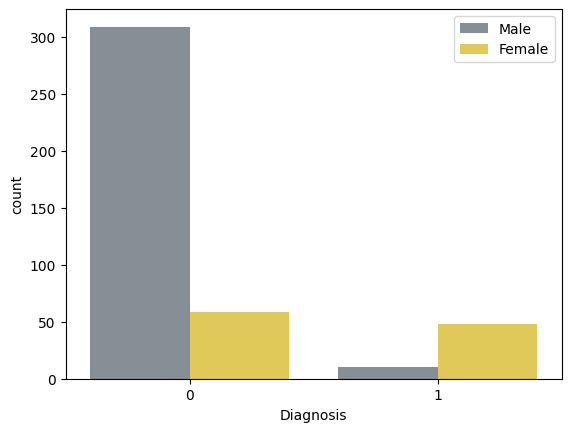

In [14]:
# SNIPPET 19
sns.countplot(x='Diagnosis', hue='Sex', data=dataset_df, palette=['#839098', '#f7d842'])
plt.legend(['Male', 'Female'])
plt.show()

2.4. Can you think of any confounding variables that may be influencing the result?  